In [15]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('ElectricCarData_Clean.csv')
data.head(4)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,D,5,68040


In [3]:
data.columns,data.shape

(Index(['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
        'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
        'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro'],
       dtype='object'),
 (103, 14))

In [4]:
col_list = list(data.columns)
topview_data = pd.DataFrame()
for col in col_list:
    datum = pd.DataFrame({'colname':col,
                          '#uniq_':[len(data[col].unique())],
                          'dtype':[data[col].dtype],
                          '#missing_':[data[col].isna().sum()],
                          'is_PKey':[len(data[col].unique()) == data.shape[0]]})
    topview_data = pd.concat([topview_data,datum],axis = 0)
    print(f'processing col :{col}')
    
topview_data

processing col :Brand
processing col :Model
processing col :AccelSec
processing col :TopSpeed_KmH
processing col :Range_Km
processing col :Efficiency_WhKm
processing col :FastCharge_KmH
processing col :RapidCharge
processing col :PowerTrain
processing col :PlugType
processing col :BodyStyle
processing col :Segment
processing col :Seats
processing col :PriceEuro


,colname,#uniq_,dtype,#missing_,is_PKey
0,Brand,33,object,0,False
0,Model,102,object,0,False
0,AccelSec,55,float64,0,False
0,TopSpeed_KmH,25,int64,0,False
0,Range_Km,50,int64,0,False
0,Efficiency_WhKm,54,int64,0,False
0,FastCharge_KmH,51,object,0,False
0,RapidCharge,2,object,0,False
0,PowerTrain,3,object,0,False
0,PlugType,4,object,0,False


[Inference:]
> From the above Data Structure Analysis, we can directly infer that on feature individually is the primary key of the data.
> Hence based on the context of the data we must investigate if Brand + Model together is the primary key of the data. 
> Also, we can see that the above data doesnot have any missing values, in order to truly validate we must manually check in the data as sometimes missing values can be replaced by special symbols

In [5]:
data['brand_model_key'] = data['Brand'].astype(str) + data['Model'].astype(str)
len(data['brand_model_key'].unique()), len(data['brand_model_key'].unique()) == data.shape[0]

(102, False)

In [6]:
BM_array = data[['Brand','Model']].drop_duplicates()
BM_array.shape,data[['Brand','Model']].shape

((102, 2), (103, 2))

[Inference:]
> This clearly tells us that there must be a brand & model that is repeating in the columns 'Brand' & 'Model'.
> If this is the case then we must find out whether this brand & model has the same entries of the car-parameters.  

[Missing Values : FastCharge_KmH]
> Based on the nature of missing values we can use direct imputation method

In [7]:
data.loc[data['FastCharge_KmH'] == '-',['Brand','Model','FastCharge_KmH']]

,Brand,Model,FastCharge_KmH
57,Renault,Twingo ZE,-
68,Renault,Kangoo Maxi ZE 33,-
77,Smart,EQ forfour,-
82,Smart,EQ fortwo coupe,-
91,Smart,EQ fortwo cabrio,-


In [11]:
data['FastCharge_KmH'] = data['FastCharge_KmH'].replace('-',0)

In [8]:
brand_modellist = list(data.loc[data['FastCharge_KmH'] == '-'].brand_model_key.unique())
BM_dict = {}
for BM in brand_modellist:
    BM_dict[BM] = []

In [9]:
BM_dict

{'Renault Twingo ZE': [],
 'Renault Kangoo Maxi ZE 33': [],
 'Smart EQ forfour ': [],
 'Smart EQ fortwo coupe': [],
 'Smart EQ fortwo cabrio': []}

[EDA]

[Feature : AccelSec] > Accleration Seconds

In [10]:
data.AccelSec.describe()

count    103.000000
mean       7.396117
std        3.017430
min        2.100000
25%        5.100000
50%        7.300000
75%        9.000000
max       22.400000
Name: AccelSec, dtype: float64

In [3]:
brandaccelgrp = data.groupby('Brand').agg(avg_AccelSec = pd.NamedAgg('AccelSec','median'),
                                          min_AccelSec = pd.NamedAgg('AccelSec','min'),
                                          max_AccelSec = pd.NamedAgg('AccelSec','max'),
                                          models = pd.NamedAgg('Model','count')).reset_index().sort_values('avg_AccelSec',ascending = True)
brandaccelgrp

,Brand,avg_AccelSec,min_AccelSec,max_AccelSec,models
15,Lucid,2.80,2.8,2.8,1
24,Porsche,3.50,2.8,4.0,5
30,Tesla,3.80,2.1,7.0,13
23,Polestar,4.70,4.7,4.7,1
11,Jaguar,4.80,4.8,4.8,1
32,Volvo,4.90,4.9,4.9,1
18,Mercedes,5.10,5.0,10.0,3
1,Audi,5.70,3.5,6.8,9
8,Ford,6.30,6.0,7.0,4
4,CUPRA,6.50,6.5,6.5,1


[Inference]:


[Feature : TopSpeed_KmH]: Top Speed in kmph

In [12]:
data.TopSpeed_KmH.describe()

count    103.000000
mean     179.194175
std       43.573030
min      123.000000
25%      150.000000
50%      160.000000
75%      200.000000
max      410.000000
Name: TopSpeed_KmH, dtype: float64

In [4]:
data.groupby('Brand').agg(avg_TopSpeed_KmH = pd.NamedAgg('TopSpeed_KmH','mean'),
                          min_TopSpeed_KmH = pd.NamedAgg('TopSpeed_KmH','min'),
                          max_TopSpeed_KmH = pd.NamedAgg('TopSpeed_KmH','max'),
                          models = pd.NamedAgg('Model','count')).reset_index().sort_values('avg_TopSpeed_KmH',ascending = False)

,Brand,avg_TopSpeed_KmH,min_TopSpeed_KmH,max_TopSpeed_KmH,models
24,Porsche,254.000000,250,260,5
15,Lucid,250.000000,250,250,1
30,Tesla,244.461538,180,410,13
23,Polestar,210.000000,210,210,1
1,Audi,200.000000,180,240,9
11,Jaguar,200.000000,200,200,1
3,Byton,190.000000,190,190,3
32,Volvo,180.000000,180,180,1
8,Ford,180.000000,180,180,4
18,Mercedes,173.333333,140,200,3


[Feature: Range_Km] > Mileage

In [14]:
data.Range_Km.describe()

count    103.000000
mean     338.786408
std      126.014444
min       95.000000
25%      250.000000
50%      340.000000
75%      400.000000
max      970.000000
Name: Range_Km, dtype: float64

In [5]:
data.groupby('Brand').agg(avg_Range_Km = pd.NamedAgg('Range_Km','mean'),
                          min_Range_Km = pd.NamedAgg('Range_Km','min'),
                          max_Range_Km = pd.NamedAgg('Range_Km','max'),
                          models = pd.NamedAgg('Model','count')).reset_index().sort_values('avg_Range_Km',ascending = False)

,Brand,avg_Range_Km,min_Range_Km,max_Range_Km,models
15,Lucid,610.000000,610,610,1
14,Lightyear,575.000000,575,575,1
30,Tesla,500.769231,310,970,13
4,CUPRA,425.000000,425,425,1
23,Polestar,400.000000,400,400,1
8,Ford,395.000000,340,450,4
24,Porsche,388.000000,365,425,5
32,Volvo,375.000000,375,375,1
3,Byton,371.666667,325,400,3
11,Jaguar,365.000000,365,365,1


[Feature: Efficiency_WhKm]

In [8]:
data.Efficiency_WhKm.describe()

count    103.000000
mean     189.165049
std       29.566839
min      104.000000
25%      168.000000
50%      180.000000
75%      203.000000
max      273.000000
Name: Efficiency_WhKm, dtype: float64

In [6]:
data.groupby('Brand').agg(avg_Efficiency_WhKm = pd.NamedAgg('Efficiency_WhKm','mean'),
                          min_Efficiency_WhKm = pd.NamedAgg('Efficiency_WhKm','min'),
                          max_Efficiency_WhKm = pd.NamedAgg('Efficiency_WhKm','max'),
                          models = pd.NamedAgg('Model','count')).reset_index().sort_values('avg_Efficiency_WhKm',ascending = False)

,Brand,avg_Efficiency_WhKm,min_Efficiency_WhKm,max_Efficiency_WhKm,models
3,Byton,234.666667,222,244,3
11,Jaguar,232.000000,232,232,1
1,Audi,224.555556,188,270,9
18,Mercedes,220.000000,171,273,3
24,Porsche,209.400000,195,223,5
8,Ford,202.250000,194,209,4
30,Tesla,201.384615,153,267,13
32,Volvo,200.000000,200,200,1
20,Nissan,194.750000,164,232,8
13,Lexus,193.000000,193,193,1


[Feature: FastCharge_KmH]

In [9]:
data.FastCharge_KmH.describe()
data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(float)

count     103
unique     51
top       230
freq        6
Name: FastCharge_KmH, dtype: object

In [13]:
data.FastCharge_KmH.describe()

count    103.000000
mean     434.563107
std      219.660061
min        0.000000
25%      260.000000
50%      440.000000
75%      555.000000
max      940.000000
Name: FastCharge_KmH, dtype: float64

In [14]:
data.groupby('Brand').agg(avg_FastCharge_KmH = pd.NamedAgg('FastCharge_KmH','mean'),
                          min_FastCharge_KmH = pd.NamedAgg('FastCharge_KmH','min'),
                          max_FastCharge_KmH = pd.NamedAgg('FastCharge_KmH','max'),
                          models = pd.NamedAgg('Model','count')).reset_index().sort_values('avg_FastCharge_KmH',ascending = False)

,Brand,avg_FastCharge_KmH,min_FastCharge_KmH,max_FastCharge_KmH,models
24,Porsche,796.000000,730.0,890.0,5
30,Tesla,730.000000,480.0,940.0,13
15,Lucid,620.000000,620.0,620.0,1
23,Polestar,620.000000,620.0,620.0,1
4,CUPRA,570.000000,570.0,570.0,1
1,Audi,567.777778,450.0,850.0,9
14,Lightyear,540.000000,540.0,540.0,1
32,Volvo,470.000000,470.0,470.0,1
3,Byton,453.333333,420.0,480.0,3
2,BMW,435.000000,260.0,650.0,4


[Feature : RapidCharge]

In [27]:
data.RapidCharge.describe()

count     103
unique      2
top       Yes
freq       98
Name: RapidCharge, dtype: object

In [26]:
data.RapidCharge.value_counts()

Yes    98
No      5
Name: RapidCharge, dtype: int64

[Feature: PowerTrain]

In [24]:
data.PowerTrain.describe()

count     103
unique      3
top       AWD
freq       41
Name: PowerTrain, dtype: object

In [25]:
data.PowerTrain.value_counts()

AWD    41
FWD    37
RWD    25
Name: PowerTrain, dtype: int64

[Feature: PlugType]

In [28]:
data.PlugType.describe()

count            103
unique             4
top       Type 2 CCS
freq              90
Name: PlugType, dtype: object

In [29]:
data.PlugType.value_counts()

Type 2 CCS        90
Type 2             9
Type 2 CHAdeMO     3
Type 1 CHAdeMO     1
Name: PlugType, dtype: int64

[Feature : BodyStyle]

In [30]:
data.BodyStyle.describe()

count     103
unique      9
top       SUV
freq       45
Name: BodyStyle, dtype: object

In [31]:
data.BodyStyle.value_counts()

SUV          45
Hatchback    32
Sedan        10
Liftback      5
Pickup        3
Cabrio        3
SPV           3
MPV           1
Station       1
Name: BodyStyle, dtype: int64

[Feature : Segment]

In [32]:
data.Segment.describe()

count     103
unique      8
top         C
freq       30
Name: Segment, dtype: object

In [33]:
data.Segment.value_counts()

C    30
B    22
D    15
F    12
E    10
A     7
N     6
S     1
Name: Segment, dtype: int64

[Feature : Seats]

In [34]:
data.Seats.describe()

count    103.000000
mean       4.883495
std        0.795834
min        2.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        7.000000
Name: Seats, dtype: float64

[Feature : PriceEuro]
> Response variable {Prices in Euro}.
> This is the variable we will be modelling on top of the rest of the features in the data. 

In [35]:
data.PriceEuro.describe()

count       103.000000
mean      55811.563107
std       34134.665280
min       20129.000000
25%       34429.500000
50%       45000.000000
75%       65000.000000
max      215000.000000
Name: PriceEuro, dtype: float64

In [36]:
data.groupby('Brand').agg(avg_PriceEuro = pd.NamedAgg('PriceEuro','mean'),
                          min_PriceEuro = pd.NamedAgg('PriceEuro','min'),
                          max_PriceEuro = pd.NamedAgg('PriceEuro','max'),
                          models = pd.NamedAgg('Model','count')).reset_index().sort_values('avg_PriceEuro',ascending = False)

,Brand,avg_PriceEuro,min_PriceEuro,max_PriceEuro,models
14,Lightyear,149000.000000,149000,149000,1
24,Porsche,138265.800000,102945,180781,5
15,Lucid,105000.000000,105000,105000,1
1,Audi,80593.666667,55000,125000,9
30,Tesla,80272.307692,45000,215000,13
11,Jaguar,75351.000000,75351,75351,1
18,Mercedes,61705.000000,45000,70631,3
32,Volvo,60437.000000,60437,60437,1
3,Byton,59833.333333,53500,64000,3
23,Polestar,56440.000000,56440,56440,1


C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PriceEuro', ylabel='Density'>

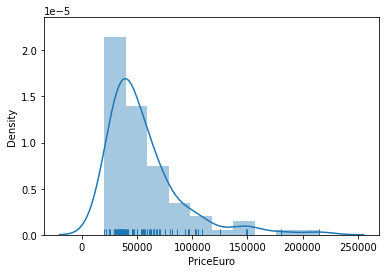

In [38]:
sns.distplot(data.PriceEuro,bins = 10,rug = True)